In [2]:
import os
import sys
import pandas
import numpy, scipy, sklearn

import findspark
findspark.init("/opt/local/spark/spark")

import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as func

from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
import pyspark.mllib.linalg.distributed
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors
from pyspark.mllib.stat import Statistics

In [122]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [123]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

In [124]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,:4].values
y = df.iloc[:,4].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [139]:
mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(numpy.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



In [140]:
S_W = numpy.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = numpy.zeros((4,4))
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1)
        class_sc_mat += (row - mv).dot((row - mv).T)
    print(class_sc_mat)
    S_W += class_sc_mat

[[6.0882 4.9146 0.7908 0.5168]
 [4.9146 7.1138 0.5724 0.5604]
 [0.7908 0.5724 1.4752 0.2792]
 [0.5168 0.5604 0.2792 0.5632]]
[[13.0552  4.174   8.962   2.7332]
 [ 4.174   4.825   4.05    2.019 ]
 [ 8.962   4.05   10.82    3.582 ]
 [ 2.7332  2.019   3.582   1.9162]]
[[19.8128  4.5944 14.8612  2.4056]
 [ 4.5944  5.0962  3.4976  2.3338]
 [14.8612  3.4976 14.9248  2.3924]
 [ 2.4056  2.3338  2.3924  3.6962]]


In [154]:
S_W

array([[38.9562, 13.683 , 24.614 ,  5.6556],
       [13.683 , 17.035 ,  8.12  ,  4.9132],
       [24.614 ,  8.12  , 27.22  ,  6.2536],
       [ 5.6556,  4.9132,  6.2536,  6.1756]])

In [145]:
numpy.cov(X[y == cl], rowvar=False) * (X[y == cl].shape[0] - 1)

array([[19.8128,  4.5944, 14.8612,  2.4056],
       [ 4.5944,  5.0962,  3.4976,  2.3338],
       [14.8612,  3.4976, 14.9248,  2.3924],
       [ 2.4056,  2.3338,  2.3924,  3.6962]])

In [28]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)


between-class Scatter Matrix:
 [[ 63.21213333 -19.534      165.16466667  71.36306667]
 [-19.534       10.9776     -56.0552     -22.4924    ]
 [165.16466667 -56.0552     436.64373333 186.90813333]
 [ 71.36306667 -22.4924     186.90813333  80.60413333]]


In [29]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.20490976]
 [-0.38714331]
 [ 0.54648218]
 [ 0.71378517]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.00898234]
 [-0.58899857]
 [ 0.25428655]
 [-0.76703217]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8843662 ]
 [ 0.28544073]
 [ 0.2580474 ]
 [ 0.26425659]]
Eigenvalue 3: 3.42e-15

Eigenvector 4: 
[[-0.22342193]
 [-0.25229799]
 [-0.32596888]
 [ 0.88327383]]
Eigenvalue 4: 1.15e-14


In [30]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])


Eigenvalues in decreasing order:

32.27195779972981
0.27756686384003953
1.1483362279322388e-14
3.422458920849769e-15


In [31]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [33]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

In [34]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

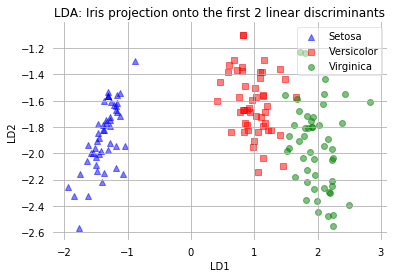

In [35]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()


In [1]:
import sklearn

In [3]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [212]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

In [214]:
X_r2[:10,:10]

array([[ 8.06179978,  0.30042062],
       [ 7.12868772, -0.78666043],
       [ 7.48982797, -0.26538449],
       [ 6.81320057, -0.67063107],
       [ 8.13230933,  0.51446253],
       [ 7.70194674,  1.46172097],
       [ 7.21261762,  0.35583621],
       [ 7.60529355, -0.01163384],
       [ 6.56055159, -1.01516362],
       [ 7.34305989, -0.94731921]])

In [6]:
lda.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [250]:
conf = pyspark.SparkConf().setMaster("local[*]").set("spark.driver.memory", "4G").set("spark.executor.memory", "4G")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-27-b848b1fa3d33>:2 

In [251]:
file_name = "/home/simon/PROJECTS/koios/analysis/iris.tsv"

In [252]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [253]:
for i, x in enumerate(df.columns):
    df = df.withColumn(x, df[x].cast("double"))

df = df.fillna(0)

In [254]:
features = df.columns[:4]
features

['s1', 's2', 'p1', 'p2']

In [383]:
Xm = (df.select(features).rdd.map(list))

In [384]:
targets = df.select("t").distinct() 
targets = targets.toPandas().values.flatten()

In [424]:
type(targets)

numpy.ndarray

In [386]:
summa = Statistics.colStats(Xm)
means_all = summa.mean()

In [387]:
means_t = numpy.zeros((3, 4))

In [388]:
for i, target in enumerate(targets):
    df_t = df.filter("t == {}".format(target))
    X_t = df_t.select(features).rdd.map(list)
    means_t[i, :] =  Statistics.colStats(X_t).mean()
means_t

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

In [261]:
numpy.mean(iris.data, axis=0)

array([5.84333333, 3.05733333, 3.758     , 1.19933333])

In [262]:
Xs  = RowMatrix(df.filter("t == {}".format(target)).rdd.map(list))

In [366]:
S_W = numpy.zeros((4, 4))
for target in targets:
    df_t = df.filter("t == {}".format(target))
    X_t = RowMatrix(df_t.select(features).rdd.map(list))
    cov_t = X_t.computeCovariance().toArray() * (df_t.count() - 1)
    S_W += cov_t

In [367]:
S_W

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

In [368]:
S_B = numpy.zeros((4, 4))
means_all = means_all.reshape(4, 1)
for i, mean_vec in enumerate(means_t):  
    mean_vec = mean_vec.reshape(4, 1)
    n = df.filter("t == {}".format(i)).count()
    S_B += n * (mean_vec - means_all).dot((mean_vec - means_all).T)
S_B

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

In [369]:
SS = RowMatrix(df.select(features).rdd.map(list)).computeCovariance()

In [425]:
S_B = SS.toArray() * df.count() - S_W
S_B

Py4JJavaError: An error occurred while calling o1016.count.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange SinglePartition
+- *(1) HashAggregate(keys=[], functions=[partial_count(1)], output=[count#1479L])
   +- *(1) FileScan csv [] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/simon/PROJECTS/koios/analysis/iris.tsv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<>

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:374)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:296)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2831)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2830)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2830)
	at sun.reflect.GeneratedMethodAccessor75.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:100)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1486)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:103)
	at org.apache.spark.sql.execution.datasources.FileFormat$class.buildReaderWithPartitionValues(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:165)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:312)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:310)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDDs(DataSourceScanExec.scala:330)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 36 more


In [457]:
eig_vals, eig_vecs = numpy.linalg.eig(numpy.linalg.inv(S_W).dot(S_B))

In [458]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [446]:
idx = numpy.argsort(-abs(eig_vals))

In [456]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [451]:
eig_vecs[:,idx]

array([[-0.20874182,  0.00653196, -0.05756863,  0.6263798 ],
       [-0.38620369,  0.58661055, -0.3169543 , -0.44389328],
       [ 0.55401172, -0.25256154, -0.38861031, -0.47751839],
       [ 0.7073504 ,  0.76945309,  0.86325422,  0.42729766]])

In [372]:
import numpy as np

In [459]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.41469382377064
0.2940178281440469
0.006711409395977925
0.006711409395636486


In [460]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Variance explained:

eigenvalue 1: 99.06%
eigenvalue 2: 0.90%
eigenvalue 3: 0.02%
eigenvalue 4: 0.02%


In [442]:
eig_vecs = eig_vecs.T

In [455]:
eig_vecs

array([[-0.20874182,  0.00653196,  0.6263798 , -0.05756863],
       [-0.38620369,  0.58661055, -0.44389328, -0.3169543 ],
       [ 0.55401172, -0.25256154, -0.47751839, -0.38861031],
       [ 0.7073504 ,  0.76945309,  0.42729766,  0.86325422]])

In [454]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [461]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

In [377]:
tmp_dense = DenseMatrix(numRows=W.shape[0], numCols=W.shape[1], values=W.flatten())
X_lda = RowMatrix(df.select(features).rdd.map(list)).multiply(tmp_dense)

In [378]:
XL = spark.createDataFrame(X_lda.rows.map(lambda x: (x,))).toPandas()

In [379]:
YM = iris.data.dot(W)

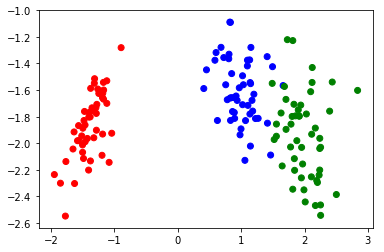

In [380]:
plt.scatter(YM[:,0],-1*YM[: ,1], color=[["red", "blue", "green"][x] for x in y])

In [391]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names



In [399]:
t = timeit.Timer('char in text', setup='text = "sample string"; char = "g"')

In [403]:
import time

In [420]:
d = time.time()
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
_ = lda.fit_transform(X, y)
print(time.time() - d)

0.0049397945404052734


In [419]:
d = time.time()
lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
_ = lda.fit_transform(X, y)
print(time.time() - d)

0.003131389617919922


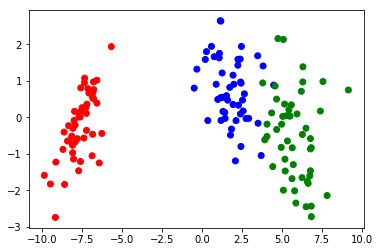

In [382]:
plt.scatter(-1*s[:,0], -1*s[: ,1], color=[["red", "blue", "green"][x] for x in y])

In [243]:
W

array([[-0.20874182, -0.00653196],
       [-0.38620369, -0.58661055],
       [ 0.55401172,  0.25256154],
       [ 0.7073504 , -0.76945309]])

In [421]:
spark.stop()